## Семинар 2 "Распознавание рукописных цифр"

ФИО: Моисеенков Павел Сергеевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
## Usage example:

#for X, y in train_loader:
#    X = X.view(X.shape[0], -1)
#    X = X.numpy() ### Converts torch.Tensor to numpy array
#    y = y.numpy()
#    pass

In [4]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

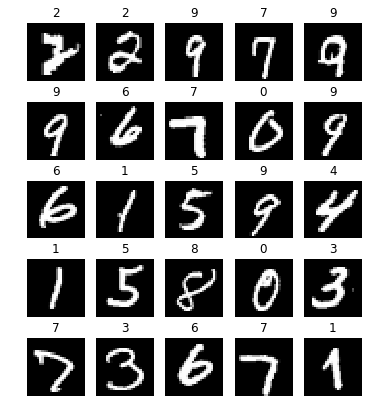

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [6]:
def train(network, epochs, learning_rate, plot=True, verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [7]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.318/0.311	Accuracy: 0.917/0.918

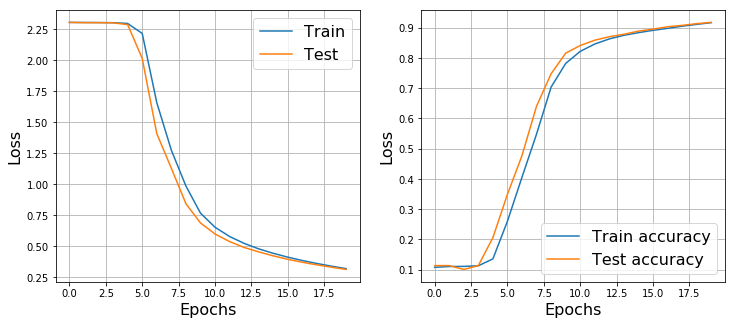

In [8]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

In [9]:
ts_ac_s[-1]

0.9178314696485623

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [10]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = (self.X >= 0).astype(float)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [11]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [12]:
network = NeuralNetwork([Linear(784, 100), ReLU(),
               Linear(100, 100), ReLU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=False, verbose=False)

In [13]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=False, verbose=False)

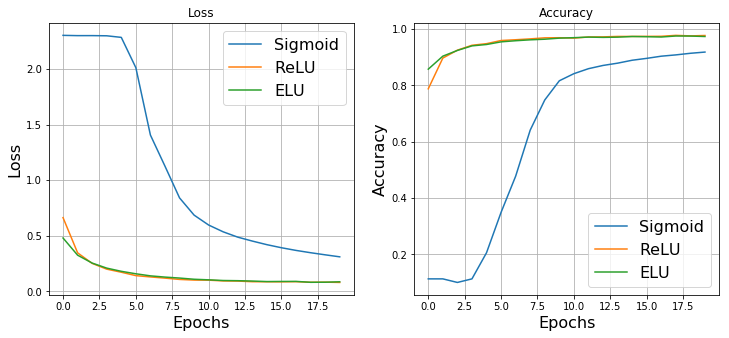

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

In [15]:
ts_ac_s[-1]

0.9178314696485623

In [16]:
ts_ac_r[-1]

0.9766373801916933

In [17]:
ts_ac_e[-1]

0.9730431309904153

### HW1 (1 балл): Реализовать Tanh

(e^x-e^(-x))/(e^x+e^(-x))

Производную гиперболического тангеса выразим через гиперб. тангес

In [18]:
class Tanh():
    def __init__(self):
        pass

    def forward(self, X):
        self.data = np.tanh(X)
        return self.data

    def backward(self, dLdy):
        dydX = 1 - self.data**2
        return dLdy*dydX
    
    def step(self, learning_rate):
        pass

In [19]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])

In [20]:
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01, plot=False, verbose=False)

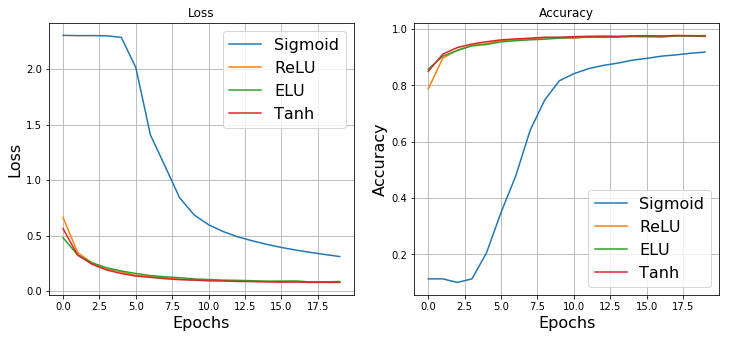

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

In [22]:
ts_ac_t[-1]

0.9749400958466453

Tanh дал наилучший Accuracy

# Часть 3: Анализ ошибок

На каких объектах сеть ошибается больше всего?

In [23]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

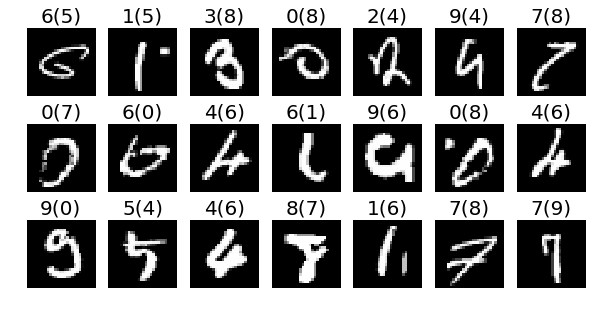

In [24]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

## Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [25]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])

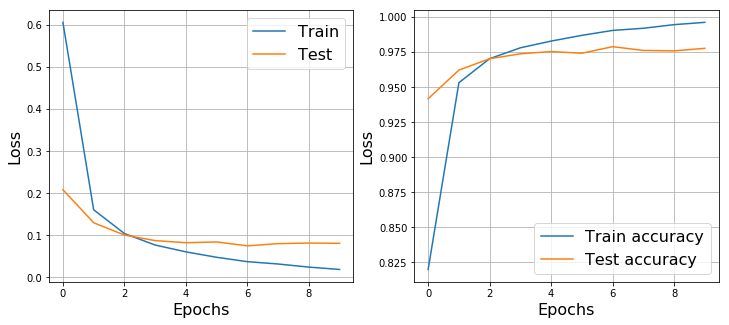

In [26]:
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 10, 0.04, plot=True, verbose=False)

In [27]:
ts_ac_t[-1]

0.9774361022364217

#### Функция тренировки с аугментацией

In [28]:
def Train_Augmentation(transform):
    train_dataset = MNIST('.', train=True, download=True, transform=transform)
    test_dataset = MNIST('.', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    
    network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
    
    tr_, ts_, tr_ac_, ts_ac_ = train(network, 10, 0.04, plot=False, verbose=True)

    return ts_ac_

### 1) Небольшие вращения (-15, 15)

In [29]:
import pandas as pd
Accur_aug = pd.DataFrame(columns=['rotation', 'affine', 'noise', 'all'], index=range(10))

In [30]:
transform = transforms.Compose([
                   transforms.RandomRotation(degrees=(-15,15)),
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
                ])

In [31]:
Accur_aug['rotation'] = Train_Augmentation(transform)

Epoch 9... (Train/Test) NLL: 0.019/0.074	Accuracy: 0.996/0.978

### 2) Случайные сдвиги

In [32]:
transform = transforms.Compose([
                   transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
                ])

In [33]:
Accur_aug['affine'] = Train_Augmentation(transform)

Epoch 9... (Train/Test) NLL: 0.019/0.079	Accuracy: 0.995/0.975

### 3) Шум

In [34]:
transform = transforms.Compose([
                       transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [35]:
Accur_aug['noise'] = Train_Augmentation(transform)

Epoch 9... (Train/Test) NLL: 0.018/0.077	Accuracy: 0.996/0.978

### 4) Всё вместе

In [41]:
transform = transforms.Compose([
                       transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                       transforms.RandomRotation(degrees=(-15,15)),
                       transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [42]:
Accur_aug['all'] = Train_Augmentation(transform)

Epoch 9... (Train/Test) NLL: 0.018/0.081	Accuracy: 0.996/0.974

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Нелинейности ReLU, ELU и Tanh дали примерно одинаковое качество. У сигмоиды оно оказалось хуже и сходится она дольше. 

Предобработка данных с помощью аугментации не дала значительного преимущества в этой задаче. Я думаю это связано с тем, что наш изначальный датасет был и так достаточно большой и хороший.  
Однако она будет необходима в задачах с маленьким датасетом. 